# Dog_Food_Vehicle Classification

In [1]:
import torch
import torchvision
from torchmetrics.classification import MulticlassAccuracy

import matplotlib.pyplot as plt
import numpy as np

#### Calculating the mean and standard deviation for Normalizing the input data

In [2]:
data_set = torchvision.datasets.ImageFolder('data/cnn_dataset/', 
                                            transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))

data_loader = torch.utils.data.DataLoader(data_set, batch_size = int(len(data_set)), shuffle=True)
for data in data_loader:
    output = data[0]
    

# Calculating Mean and Standard deviation
mean_set = output.view([30000,3,-1]).mean(2).sum(0)/len(data_set)
std_set = output.view([30000,3,-1]).std(2).sum(0)/len(data_set)

print('The Mean we use to normalize the data:{0}'.format(mean_set))
print('The Standard Deviation we use to normalize the data:{0}'.format(std_set))


The Mean we use to normalize the data:tensor([0.5047, 0.4501, 0.3841])
The Standard Deviation we use to normalize the data:tensor([0.2378, 0.2380, 0.2392])


The encoded labels of the images are tensor([0, 2, 2]):
Labels are Encoded as follows {'dogs': 0, 'food': 1, 'vehicles': 2}:


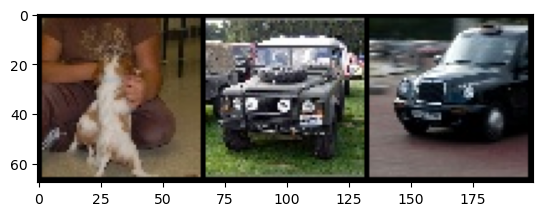

In [3]:
def matplotlib_imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(data_loader)
images, labels = next(dataiter)
images = images[:3]
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid)
print('The encoded labels of the images are {0}:'.format(labels[:3]))
print('Labels are Encoded as follows {0}:'.format(data_set.class_to_idx))

In [4]:
del(data_set)
del(data_loader)
del(output)

In [5]:
MPS = torch.device('mps')

#### Loading the Image data

In [6]:
transformer = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean_set, std=std_set)
    ])
full_data_set = torchvision.datasets.ImageFolder('data/cnn_dataset/', transform = transformer)

In [7]:
print('Output targets are encoded as follows: {0}'.format(full_data_set.class_to_idx))

Output targets are encoded as follows: {'dogs': 0, 'food': 1, 'vehicles': 2}


In [8]:
print('The size of the dataset is; {0}'.format(len(full_data_set)))

The size of the dataset is; 30000


#### Creating Training and Testing dataset

In [9]:
test_size = int(len(full_data_set)*0.05)
train_size = int(len(full_data_set)*0.95)
train_data_set, test_data_set = torch.utils.data.random_split(full_data_set, [train_size,test_size])

In [10]:
train_data_loader = torch.utils.data.DataLoader(train_data_set, batch_size=int(train_size/12), shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_data_set, batch_size=test_size, shuffle=True)

#### Learning Loop

In [12]:
loss_criteria = torch.nn.CrossEntropyLoss()
multiclass_accuracy  = MulticlassAccuracy(num_classes=len(full_data_set.classes)).to(device=MPS)

In [13]:
def one_epoch_train(model: torch.nn.Module, data_loader_train: torch.utils.data.DataLoader, 
                    loss_criterion: torch.nn, optim_alog: torch.optim) -> tuple:
    """Function that trains the model for one epoch.

    Args:
        model (torch.nn.Module): Pytorch model we want to train.
        data_loader_train (torch.utils.data.DataLoader): Pytorch dataloader that carries training data.
        loss_criterion (torch.nn): Pytorch loss criteria on which we calculate loss.
        optim_alog (torch.optim): Opimiztion algoritham that we use to update model weights.

    Returns:
        tuple: Output tensor carrying predicted probability of each class.
    """
    batch_loss_train = []
    batch_accuracy_train = []
    batch_counter = 0
    for inputs, labels in data_loader_train:
        inputs = inputs.to(device=MPS)
        labels = labels.to(device=MPS)
        
        # Enabling model training.
        model.train(True)
        
        #Setting gradients to zero to prevent gradient accumulation.
        optim_alog.zero_grad()
        
        # Forward pass.
        y_pred_prob = model(inputs)
        loss = loss_criterion(y_pred_prob, labels)
        
        batch_loss_train.append(loss.item())
        
        # Back Propagation
        loss.backward()
        
        # Updating weights
        optim_alog.step()
        
        # Calculating training accuracy.
        with torch.inference_mode():
            accuracy = multiclass_accuracy(y_pred_prob, labels)
            batch_accuracy_train.append(accuracy.item())
        batch_counter += 1
        
        del(inputs)
        del(labels)
        
    return sum(batch_loss_train)/batch_counter, sum(batch_accuracy_train)/batch_counter

In [14]:
def training_loop(model: torch.nn.Module, data_loader_train: torch.utils.data.DataLoader, data_loader_test: torch.utils.data.DataLoader, 
                  epochs:int, loss_criterion: torch.nn, optim_alog: torch.optim, learning_rate_scheduler:torch.optim =None)-> dict:
    """Function that trains the model for the given number of epochs

    Args:
        model (torch.nn.Module): Pytorch model we want to train.
        data_loader_train (torch.utils.data.DataLoader): Pytorch dataloader that carries training data.
        data_loader_test (torch.utils.data.DataLoader): Pytorch dataloader that carries testing data.
        epochs (int): Count of EPOCHS
        loss_criterion (torch.nn): Pytorch loss criteria on which we calculate loss.
        optim_alog (torch.optim): Opimiztion algoritham that we use to update model weights.
        learning_rate_scheduler (torch.optim, optional): Learning rate scheduler to decrease the learning rate. Defaults to None.

    Returns:
        dict: A dictionary that carries the output metrics.
    """
    
    loss_train = []
    loss_test = []
    
    accuracy_train = []
    accuracy_test = []
    
    # Loop that iterates over each EPOCH
    for epoch in range(epochs):
        
        #Train the model for one EPOCH
        epoch_loss, epoch_accuracy = one_epoch_train(model, data_loader_train, loss_criterion, optim_alog)
        loss_train.append(epoch_loss)
        accuracy_train.append(epoch_accuracy)
        
        model.train(False)
        inputs, labels = next(iter(data_loader_test))
        inputs = inputs.to(device=MPS)
        labels = labels.to(device=MPS)
        
        # Making a forward pass of Test data
        with torch.inference_mode():
            y_pred_prob = model(inputs)
            #Calculate the test loss.
            print(labels.shape)
            print(y_pred_prob.shape)
            loss = loss_criteria(y_pred_prob, labels)
            
            # If learning rate us being used then update the learning rate
            if learning_rate_scheduler is not None:
                learning_rate_scheduler.step(loss)
            loss_test.append(loss.item())
            # Calculate Test Accuracy.
            accuracy = multiclass_accuracy(y_pred_prob, labels)
            accuracy_test.append(accuracy.item())
        del(inputs)
        del(labels)
        
        if (epoch+1)%5 == 0:
            print('For Epoch {} We Train Loss:{}, Test Loss:{}, Train Accuracy:{}, Test Accuracy:{}'.format(epoch+1, epoch_loss,
                                                                                                        loss.item(),
                                                                                                        epoch_accuracy,
                                                                                                        accuracy.item()))
    return {'training_loss':loss_train, 'testing_loss':loss_test, 'training_accuracy':accuracy_train, 'testing_accuracy':accuracy_test}
            

In [15]:
def plot_metrics(epochs: int,metrics: dict) -> None:
    """Plot the graphs of Training and Testing Accuracy and Loss across Epoches

    Args:
        epochs (int): Number of Epochs
        metrics (dict): A dictionary containing Test and Training datasets' Loss and accuracy
    """
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(list(range(epochs)), metrics['training_loss'])
    plt.plot(list(range(epochs)), metrics['testing_loss'])
    plt.grid()
    plt.legend(['Train', 'Test'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Test loss across epochs')
    
    plt.subplot(1,2,2)
    plt.plot(list(range(epochs)), metrics['training_accuracy'])
    plt.plot(list(range(epochs)), metrics['testing_accuracy'])
    plt.grid()
    plt.legend(['Train', 'Test'])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Test accuracy across epochs')
    
    plt.show()

#### AlexNet

In [16]:
class AlexNet(torch.nn.Module):
    
    def __init__(self: 'AlexNet', input_size: int)-> None:
        """Function to initate the model layers

        Args:
            input_size (int): Input size of the image
        """
        super(AlexNet,self).__init__()
    
        self.max_pool = torch.nn.MaxPool2d(kernel_size=3)
        
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11)
        conv1_size = self._get_conv_output_size(input_size, self.conv1.padding[0], self.conv1.stride[0], self.conv1.kernel_size[0])
        pool1_size = self._get_conv_output_size(conv1_size, self.max_pool.padding, self.max_pool.stride, self.max_pool.kernel_size)
        
        self.conv2 = torch.nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2)
        conv2_size = self._get_conv_output_size(pool1_size, self.conv2.padding[0], self.conv2.stride[0], self.conv2.kernel_size[0])
        pool2_size = self._get_conv_output_size(conv2_size, self.max_pool.padding, self.max_pool.stride, self.max_pool.kernel_size)
        
        self.conv3 = torch.nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1)
        conv3_size = self._get_conv_output_size(pool2_size, self.conv3.padding[0], self.conv3.stride[0], self.conv3.kernel_size[0])
        
        self.conv4 = torch.nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1)
        conv4_size = self._get_conv_output_size(conv3_size, self.conv4.padding[0], self.conv4.stride[0], self.conv4.kernel_size[0])
        
        self.conv5 = torch.nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1)
        conv5_size = self._get_conv_output_size(conv4_size, self.conv5.padding[0], self.conv5.stride[0], self.conv5.kernel_size[0])
        pool3_size = self._get_conv_output_size(conv5_size, self.max_pool.padding, self.max_pool.stride, self.max_pool.kernel_size)
        
        self.linear1 = torch.nn.Linear(in_features=self.conv5.out_channels*pool3_size*pool3_size, out_features=4096)
        self.linear2 = torch.nn.Linear(in_features=4096, out_features=4096)
        self.linear3 = torch.nn.Linear(in_features=4096, out_features=3)
        
        self.dropout = torch.nn.Dropout(p=0.5)
        
        self.softmax = torch.nn.Softmax(dim=1)
        
    
    def _get_conv_output_size(self: 'AlexNet', input_size: int, padding: int, stride: int, kernel_size: int) -> int:
        """Funtion that calculate the output convolution size

        Args:
            input_size (int): Size of the input
            padding (int): Padding size
            stride (int): Stride count
            kernel_size (int): Size of the Kernel

        Returns:
            int: Output convolution size.
        """
        return ((input_size+ (2* padding) - kernel_size)//stride)+1
        
    
    def forward(self: 'AlexNet', x: torch.Tensor) -> torch.Tensor:
        """Function that performs the forward pass of the Neural Network

        Args:
            x (torch.Tensor): Input Tensor that carries that information about a batch of images

        Returns:
            torch.Tensor: Output tensor that carries the predicted probability of each class.
        """
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.max_pool(x)
        
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = self.max_pool(x)
        
        x = self.conv3(x)
        x = torch.nn.functional.relu(x)
        
        x = self.conv4(x)
        x = torch.nn.functional.relu(x)
        
        x = self.conv5(x)
        x = torch.nn.functional.relu(x)
        x = self.max_pool(x)
        
        x = torch.flatten(x, start_dim=1)
        x = self.linear1(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout(x)
        
        x = self.linear2(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout(x)
        
        x = self.linear3(x)
        x = self.softmax(x)
        
        return x

In [17]:
torch.manual_seed(18)
alx_model =AlexNet(64).to(device=MPS)
alx_model

AlexNet(
  (max_pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(1, 1))
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear1): Linear(in_features=1024, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=4096, bias=True)
  (linear3): Linear(in_features=4096, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (softmax): Softmax(dim=1)
)

In [18]:
EPOCHS = 50
optimizer = torch.optim.Adam(alx_model.parameters(), lr=3e-4)

In [19]:
output_metrics = training_loop(alx_model,train_data_loader,test_data_loader,EPOCHS,loss_criteria,optimizer)

/Users/shri/Documents/programming_environments/pytorch_env/lib/python3.11/site-packages/torchmetrics/functional/classification/stat_scores.py:416: UserWarning: MPS: no support for int64 reduction ops, casting it to int32 (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/ReduceOps.mm:144.)
  fp = confmat.sum(0) - tp


torch.Size([1500])
torch.Size([1500, 3])


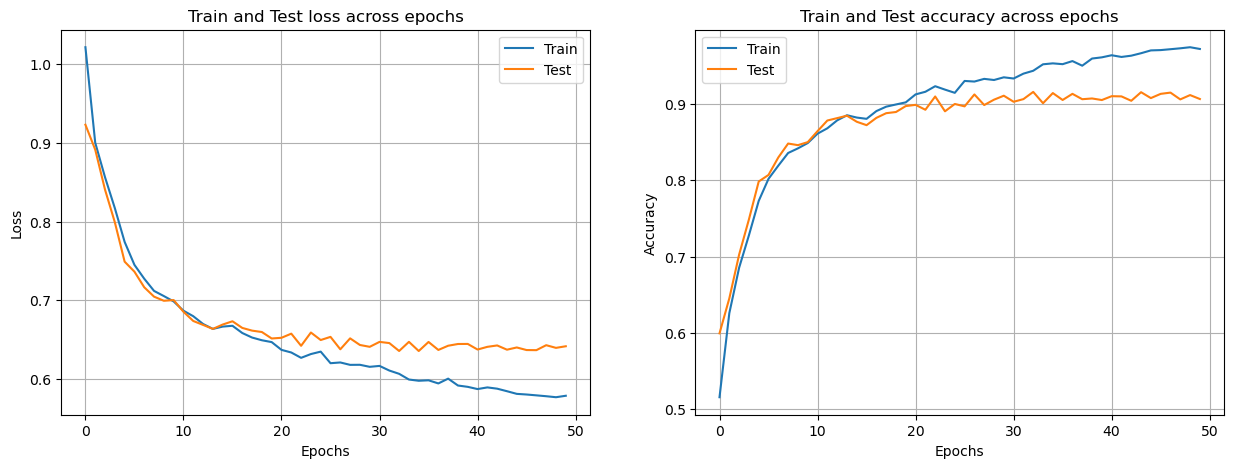

In [24]:
plot_metrics(EPOCHS, output_metrics)

In [25]:
del(alx_model)

#### Improved Model

* There is no significant overfitting becuase of the complexity of the model so we will remove dropout layers.
* We have clearly seen that around after 15 iterations the training error is going down but the testing error is not showing any signifincant improvement. So we will use ReduceOnPlateau learning rate scheduler to decrease the learning rate on testing loss became stagnant.
* To decrease the overload over the model and improve the training time we will increase the batchs count.

In [15]:
del(train_data_loader)
train_data_loader = torch.utils.data.DataLoader(train_data_set, batch_size=int(train_size/25), shuffle=True)

In [17]:
class ImpAlexNet(torch.nn.Module):
    
    def __init__(self: 'ImpAlexNet', input_size: int)-> None:
        """Function to initate the model layers

        Args:
            input_size (int): Input size of the image
        """
        super(ImpAlexNet,self).__init__()
    
        self.max_pool = torch.nn.MaxPool2d(kernel_size=3)
        
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11)
        conv1_size = self._get_conv_output_size(input_size, self.conv1.padding[0], self.conv1.stride[0], self.conv1.kernel_size[0])
        pool1_size = self._get_conv_output_size(conv1_size, self.max_pool.padding, self.max_pool.stride, self.max_pool.kernel_size)
        
        self.conv2 = torch.nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2)
        conv2_size = self._get_conv_output_size(pool1_size, self.conv2.padding[0], self.conv2.stride[0], self.conv2.kernel_size[0])
        pool2_size = self._get_conv_output_size(conv2_size, self.max_pool.padding, self.max_pool.stride, self.max_pool.kernel_size)
        
        self.conv3 = torch.nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1)
        conv3_size = self._get_conv_output_size(pool2_size, self.conv3.padding[0], self.conv3.stride[0], self.conv3.kernel_size[0])
        
        self.conv4 = torch.nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1)
        conv4_size = self._get_conv_output_size(conv3_size, self.conv4.padding[0], self.conv4.stride[0], self.conv4.kernel_size[0])
        
        self.conv5 = torch.nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1)
        conv5_size = self._get_conv_output_size(conv4_size, self.conv5.padding[0], self.conv5.stride[0], self.conv5.kernel_size[0])
        pool3_size = self._get_conv_output_size(conv5_size, self.max_pool.padding, self.max_pool.stride, self.max_pool.kernel_size)
        
        self.linear1 = torch.nn.Linear(in_features=self.conv5.out_channels*pool3_size*pool3_size, out_features=4096)
        self.linear2 = torch.nn.Linear(in_features=4096, out_features=4096)
        self.linear3 = torch.nn.Linear(in_features=4096, out_features=3)
        
        self.softmax = torch.nn.Softmax(dim=1)
        
    
    def _get_conv_output_size(self: 'ImpAlexNet', input_size: int, padding: int, stride: int, kernel_size: int) -> int:
        """Funtion that calculate the output convolution size

        Args:
            input_size (int): Size of the input
            padding (int): Padding size
            stride (int): Stride count
            kernel_size (int): Size of the Kernel

        Returns:
            int: Output convolution size.
        """
        return ((input_size+ (2* padding) - kernel_size)//stride)+1
        
    
    def forward(self: 'ImpAlexNet', x: torch.Tensor) -> torch.Tensor:
        """Function that performs the forward pass of the Neural Network

        Args:
            x (torch.Tensor): Input Tensor that carries that information about a batch of images

        Returns:
            torch.Tensor: Output tensor that carries the predicted probability of each class.
        """
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.max_pool(x)
        
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = self.max_pool(x)
        
        x = self.conv3(x)
        x = torch.nn.functional.relu(x)
        
        x = self.conv4(x)
        x = torch.nn.functional.relu(x)
        
        x = self.conv5(x)
        x = torch.nn.functional.relu(x)
        x = self.max_pool(x)
        
        x = torch.flatten(x, start_dim=1)
        x = self.linear1(x)
        x = torch.nn.functional.relu(x)
        
        x = self.linear2(x)
        x = torch.nn.functional.relu(x)
        
        x = self.linear3(x)
        x = self.softmax(x)
        
        return x

In [18]:
torch.manual_seed(18)
imp_alx_model =ImpAlexNet(64).to(device=MPS)
imp_alx_model

ImpAlexNet(
  (max_pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(1, 1))
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear1): Linear(in_features=1024, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=4096, bias=True)
  (linear3): Linear(in_features=4096, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

In [19]:
EPOCHS = 40
optimizer = torch.optim.Adam(imp_alx_model.parameters(), lr=3e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

In [20]:
output_metrics = training_loop(imp_alx_model,train_data_loader,test_data_loader,EPOCHS,loss_criteria,optimizer, learning_rate_scheduler=lr_scheduler)

/Users/shri/Documents/ESDS/Semester_1/Intro_To_Machine_Learning/Assignment_2/env/lib/python3.8/site-packages/torchmetrics/functional/classification/stat_scores.py:416: UserWarning: MPS: no support for int64 reduction ops, casting it to int32 (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/ReduceOps.mm:144.)
  fp = confmat.sum(0) - tp


For Epoch 5 We Train Loss:0.7178894543647766, Test Loss:0.7044321894645691, Train Accuracy:0.8290361261367798, Test Accuracy:0.8394066095352173
For Epoch 10 We Train Loss:0.660262131690979, Test Loss:0.6510100960731506, Train Accuracy:0.888307740688324, Test Accuracy:0.8975473642349243
For Epoch 15 We Train Loss:0.6377868676185607, Test Loss:0.6471962332725525, Train Accuracy:0.9120376324653625, Test Accuracy:0.8992478847503662
For Epoch 20 We Train Loss:0.6156146359443665, Test Loss:0.6293011903762817, Train Accuracy:0.9351605725288391, Test Accuracy:0.921194314956665
For Epoch 25 We Train Loss:0.6047106170654297, Test Loss:0.6298899054527283, Train Accuracy:0.9463596558570861, Test Accuracy:0.9202867746353149
For Epoch 30 We Train Loss:0.585647132396698, Test Loss:0.6233112215995789, Train Accuracy:0.9667334008216858, Test Accuracy:0.9254617691040039
For Epoch 35 We Train Loss:0.5824409532546997, Test Loss:0.6223092675209045, Train Accuracy:0.9698726153373718, Test Accuracy:0.9278758

In [2]:
print('The testing accuracy is: {0}'.format(output_metrics['testing_accuracy'][-1]*100))

The testing accuracy is: 92.58716106414795


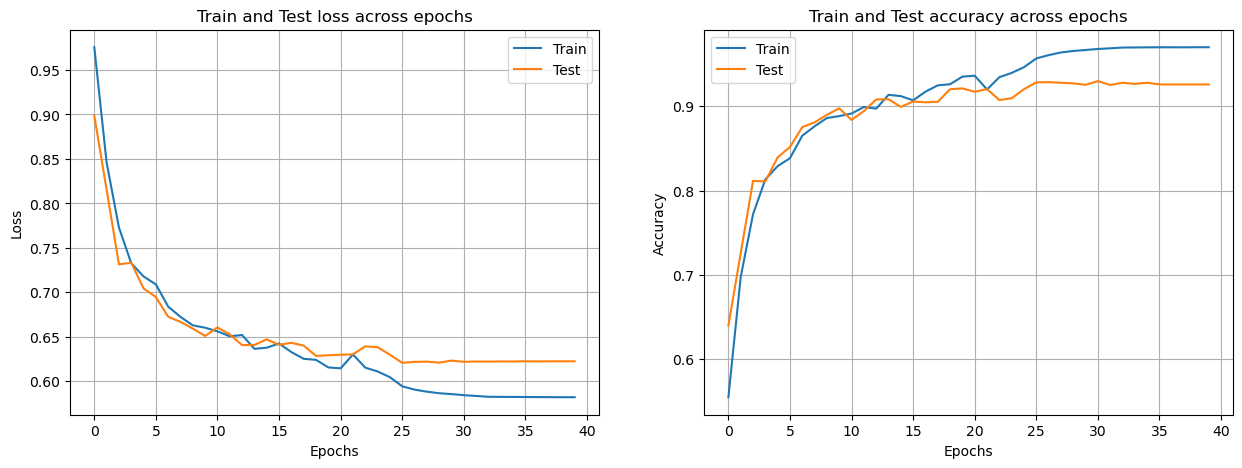

In [21]:
plot_metrics(EPOCHS, output_metrics)

In [22]:
del(imp_alx_model)

**Observations:**
* Learning happened so fast, with in 5 EPOCHS we reached to 83.9% accuracy.
* We can clearly see that because of the changes we made to 90% test accuracy just in 15 EPOCHS, in the prior experiment it took more than 20 EPOCHS
* By introducing the learning rate scheduler and using it and decreasing the learning rate when the loss became stagnant, we also improved accuracy by a couple of notches. 
* We also improved the training time to an extent.

#### VGG-13

In [2]:
import torch
import torchvision
from torchmetrics.classification import MulticlassAccuracy

import matplotlib.pyplot as plt

In [3]:
#  Maximum size of a tensor that can be split during a parallel operation on the GPU.
torch.backends.cuda.max_split_size = 512

In [4]:
### Code to unzip the file.

import zipfile

# specify the path to the zip file
zip_file = "/content/cnn_dataset.zip"

# specify the path to the directory where you want to extract the contents of the zip file
extract_dir = "/content/"

# create a ZipFile object
zip_obj = zipfile.ZipFile(zip_file)

# extract all the contents of the zip file to the specified directory
zip_obj.extractall(extract_dir)

# close the ZipFile object
zip_obj.close()

#### Calculating the mean and standard deviation for Normalizing the input data

In [5]:
data_set = torchvision.datasets.ImageFolder('/content/cnn_dataset', 
                                            transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))

data_loader = torch.utils.data.DataLoader(data_set, batch_size = int(len(data_set)))
for data in data_loader:
    output = data[0]
    

# Calculating Mean and Standard deviation
mean_set = output.view([30000,3,-1]).mean(2).sum(0)/len(data_set)
std_set = output.view([30000,3,-1]).std(2).sum(0)/len(data_set)

print('The Mean we use to normalize the data:{0}'.format(mean_set))
print('The Standard Deviation we use to normalize the data:{0}'.format(std_set))

del data_set
del data_loader
del output

The Mean we use to normalize the data:tensor([0.5048, 0.4501, 0.3840])
The Standard Deviation we use to normalize the data:tensor([0.2386, 0.2384, 0.2404])


In [6]:
MPS = torch.device('cuda')

#### Loading the Image data

In [7]:
transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((112, 112)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean_set, std=std_set)
    ])
full_data_set = torchvision.datasets.ImageFolder('/content/cnn_dataset', transform = transformer)

In [8]:
print('Output targets are encoded as follows: {0}'.format(full_data_set.class_to_idx))

Output targets are encoded as follows: {'dogs': 0, 'food': 1, 'vehicles': 2}


In [9]:
print('The size of the dataset is; {0}'.format(len(full_data_set)))

The size of the dataset is; 30000


#### Creating Training and Testing dataset

In [10]:
test_size = int(len(full_data_set)*0.05)
train_size = int(len(full_data_set)*0.95)
train_data_set, test_data_set = torch.utils.data.random_split(full_data_set, [train_size,test_size])

In [11]:
train_data_loader = torch.utils.data.DataLoader(train_data_set, batch_size=int(train_size/2048), shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_data_set, batch_size=test_size, shuffle=True)

#### Mixed Precision Learning Loop

In [12]:
loss_criteria = torch.nn.CrossEntropyLoss()
multiclass_accuracy  = MulticlassAccuracy(num_classes=len(full_data_set.classes)).to(device=MPS)

Reference:

*   Mixed Precision Training using CUDA: https://pytorch.org/docs/stable/notes/amp_examples.html



In [13]:
scaler = torch.cuda.amp.GradScaler()

In [14]:
def one_epoch_train(model, data_loader_train, loss_criterion, optim_alog):
    batch_loss_train = []
    batch_accuracy_train = []
    batch_counter = 0
    for inputs, labels in data_loader_train:
        inputs = inputs.to(device=MPS)
        labels = labels.to(device=MPS)
        
        model.train(True)
        
        optim_alog.zero_grad()
        with torch.cuda.amp.autocast():
          y_pred_prob = model(inputs)
          loss = loss_criterion(y_pred_prob, labels)
        
        batch_loss_train.append(loss.item())
        
        scaler.scale(loss).backward()
        scaler.step(optim_alog)
        scaler.update()
        
        with torch.inference_mode():
            accuracy = multiclass_accuracy(y_pred_prob, labels)
            batch_accuracy_train.append(accuracy.item())
        batch_counter += 1
        
        del(inputs)
        del(labels)
        
    return sum(batch_loss_train)/batch_counter, sum(batch_accuracy_train)/batch_counter

In [15]:
def training_loop(model, data_loader_train, data_loader_test, epochs, loss_criterion, optim_alog, learning_rate_scheduler=None):
    
    loss_train = []
    loss_test = []
    
    accuracy_train = []
    accuracy_test = []
    
    for epoch in range(epochs):
        
        epoch_loss, epoch_accuracy = one_epoch_train(model, data_loader_train, loss_criterion, optim_alog)
        loss_train.append(epoch_loss)
        accuracy_train.append(epoch_accuracy)
        
        model.train(False)
        inputs, labels = next(iter(data_loader_test))
        inputs = inputs.to(device=MPS)
        labels = labels.to(device=MPS)
        
        with torch.inference_mode():
            with torch.cuda.amp.autocast():
              y_pred_prob = model(inputs)
              loss = loss_criteria(y_pred_prob, labels)
              
            if learning_rate_scheduler is not None:
                learning_rate_scheduler.step(loss)
            loss_test.append(loss.item())
            accuracy = multiclass_accuracy(y_pred_prob, labels)
            accuracy_test.append(accuracy.item())
        del(inputs)
        del(labels)
        
        if (epoch+1)%5 == 0:
            print('For Epoch {} We Train Loss:{}, Test Loss:{}, Train Accuracy:{}, Test Accuracy:{}'.format(epoch+1, epoch_loss,
                                                                                                        loss.item(),
                                                                                                        epoch_accuracy,
                                                                                                        accuracy.item()))
    return {'training_loss':loss_train, 'testing_loss':loss_test, 'training_accuracy':accuracy_train, 'testing_accuracy':accuracy_test}
            

In [16]:
def plot_metrics(epochs: int,metrics: dict) -> None:
    """Plot the graphs of Training and Testing Accuracy and Loss across Epoches

    Args:
        epochs (int): Number of Epochs
        metrics (dict): A dictionary containing Test and Training datasets' Loss and accuracy
    """
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(list(range(epochs)), metrics['training_loss'])
    plt.plot(list(range(epochs)), metrics['testing_loss'])
    plt.grid()
    plt.legend(['Train', 'Test'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Test loss across epochs')
    
    plt.subplot(1,2,2)
    plt.plot(list(range(epochs)), metrics['training_accuracy'])
    plt.plot(list(range(epochs)), metrics['testing_accuracy'])
    plt.grid()
    plt.legend(['Train', 'Test'])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Test accuracy across epochs')
    
    plt.show()

#### VGG-13

In [17]:
class VGG13(torch.nn.Module):
    
    def __init__(self, input_size):
        super(VGG13,self).__init__()
    
        self.max_pool = torch.nn.MaxPool2d(kernel_size=3, stride=3)
        
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)
        conv1_size = self._get_conv_output_size(input_size, self.conv1.padding[0], self.conv1.stride[0], self.conv1.kernel_size[0])
        
        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        conv2_size = self._get_conv_output_size(conv1_size, self.conv2.padding[0], self.conv2.stride[0], self.conv2.kernel_size[0])
        
        pool1_size = self._get_conv_output_size(conv2_size, self.max_pool.padding, self.max_pool.stride, self.max_pool.kernel_size)
        
        self.conv3 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        conv3_size = self._get_conv_output_size(pool1_size, self.conv3.padding[0], self.conv3.stride[0], self.conv3.kernel_size[0])
        
        self.conv4 = torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3)
        conv4_size = self._get_conv_output_size(conv3_size, self.conv4.padding[0], self.conv4.stride[0], self.conv4.kernel_size[0])
        
        pool2_size = self._get_conv_output_size(conv4_size, self.max_pool.padding, self.max_pool.stride, self.max_pool.kernel_size)
        
        self.conv5 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        conv5_size = self._get_conv_output_size(pool2_size, self.conv5.padding[0], self.conv5.stride[0], self.conv5.kernel_size[0])
        
        self.conv6 = torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3)
        conv6_size = self._get_conv_output_size(conv5_size, self.conv6.padding[0], self.conv6.stride[0], self.conv6.kernel_size[0])
        
        pool3_size = self._get_conv_output_size(conv6_size, self.max_pool.padding, self.max_pool.stride, self.max_pool.kernel_size)
        
        self.conv7 = torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=4)
        conv7_size = self._get_conv_output_size(pool3_size, self.conv7.padding[0], self.conv7.stride[0], self.conv7.kernel_size[0])
        
        self.conv8 = torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3)
        conv8_size = self._get_conv_output_size(conv7_size, self.conv8.padding[0], self.conv8.stride[0], self.conv8.kernel_size[0])
        
        pool4_size = self._get_conv_output_size(conv8_size, self.max_pool.padding, self.max_pool.stride, self.max_pool.kernel_size)
        
        self.conv9 = torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=4)
        conv9_size = self._get_conv_output_size(pool4_size, self.conv9.padding[0], self.conv9.stride[0], self.conv9.kernel_size[0])
        
        self.conv10 = torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3)
        conv10_size = self._get_conv_output_size(conv9_size, self.conv10.padding[0], self.conv10.stride[0], self.conv10.kernel_size[0])
        
        pool5_size = self._get_conv_output_size(conv10_size, self.max_pool.padding, self.max_pool.stride, self.max_pool.kernel_size)
        
        self.linear1 = torch.nn.Linear(in_features=self.conv10.out_channels*pool5_size*pool5_size, out_features=4096)
        self.linear2 = torch.nn.Linear(in_features=4096, out_features=4096)
        self.linear3 = torch.nn.Linear(in_features=4096, out_features=3)
        
        self.softmax = torch.nn.Softmax(dim=1)
    
    def _get_conv_output_size(self,input_size, padding, stride, kernel_size):
        return ((input_size+ (2* padding) - kernel_size)//stride)+1
        
    
    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.relu(self.conv2(x))
        x = self.max_pool(x)
        
        x = torch.nn.functional.relu(self.conv3(x))
        x = torch.nn.functional.relu(self.conv4(x))
        x = self.max_pool(x)
        
        x = torch.nn.functional.relu(self.conv5(x))
        x = torch.nn.functional.relu(self.conv6(x))
        x = self.max_pool(x)
        
        x = torch.nn.functional.relu(self.conv7(x))
        x = torch.nn.functional.relu(self.conv8(x))
        x = self.max_pool(x)
        
        x = torch.nn.functional.relu(self.conv9(x))
        x = torch.nn.functional.relu(self.conv10(x))
        x = self.max_pool(x)
        
        x = torch.flatten(x, start_dim=1)
        x = torch.nn.functional.relu(self.linear1(x))
        x = torch.nn.functional.relu(self.linear2(x))
        x = self.linear3(x)
        x = self.softmax(x)
        
        return x

In [18]:
torch.manual_seed(18)
vgg_model =VGG13(112).to(device=MPS)
vgg_model

VGG13(
  (max_pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4))
  (conv8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv9): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4))
  (conv10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
  (linear1): Linear(in_features=2048, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=4096, bias=True)
  (linear3): Linear(in_features=4096, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

In [19]:
EPOCHS = 50
optimizer = torch.optim.Adam(vgg_model.parameters(), lr=4e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

In [20]:
output_metrics = training_loop(vgg_model,train_data_loader,test_data_loader,EPOCHS,loss_criteria,optimizer,learning_rate_scheduler=lr_scheduler)

For Epoch 5 We Train Loss:0.7106351142760232, Test Loss:0.7039946913719177, Train Accuracy:0.8324954097965673, Test Accuracy:0.8489501476287842
For Epoch 10 We Train Loss:0.690661606563589, Test Loss:0.6680534482002258, Train Accuracy:0.8555860747988779, Test Accuracy:0.8825743198394775
For Epoch 15 We Train Loss:0.6697891657340489, Test Loss:0.695013165473938, Train Accuracy:0.8749568176307583, Test Accuracy:0.8556727766990662
For Epoch 20 We Train Loss:0.8010279884416656, Test Loss:0.9489066004753113, Train Accuracy:0.742482347407952, Test Accuracy:0.5973378419876099
For Epoch 25 We Train Loss:0.6371439595609509, Test Loss:0.6452112793922424, Train Accuracy:0.9076564776207071, Test Accuracy:0.9027074575424194
For Epoch 30 We Train Loss:0.6287236957587012, Test Loss:0.6412832736968994, Train Accuracy:0.9166864055071691, Test Accuracy:0.9100316762924194
For Epoch 35 We Train Loss:0.6245722376044569, Test Loss:0.6348432898521423, Train Accuracy:0.9222763354137941, Test Accuracy:0.914649

In [24]:
print('The Test Accuracy is: {0}'.format(output_metrics['testing_accuracy'][-1]))

The Test Accuracy is: 0.914681077003479


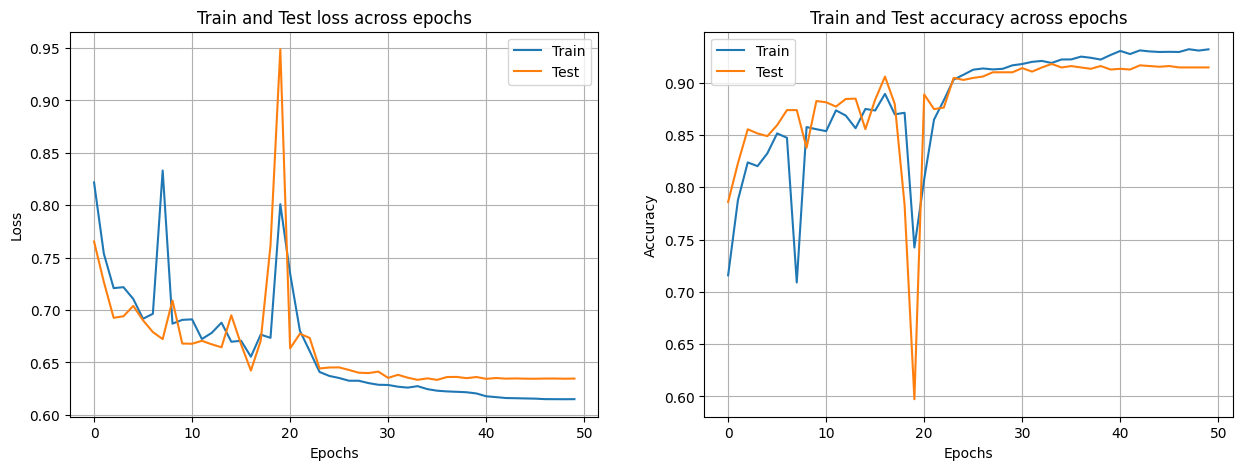

In [21]:
plot_metrics(EPOCHS, output_metrics)

In [22]:
del(vgg_model)

## Part 4 - SVHN Dataset

In [9]:
from torchvision.datasets import SVHN

#### Calculating the mean and standard deviation for Normalizing the input data

In [10]:
transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
data_set = SVHN(root='data/SVHN', split='train', transform=transformer)

print('The size of the train dataset is; {0}'.format(len(data_set)))
data_loader = torch.utils.data.DataLoader(data_set, batch_size = int(len(data_set)))
for data in data_loader:
    output = data[0]

# Calculating Mean and Standard deviation
mean_set = output.view([output.shape[0],3,-1]).mean(2).sum(0)/len(data_set)
std_set = output.view([output.shape[0],3,-1]).std(2).sum(0)/len(data_set)

print('The Mean we use to normalize the data:{0}'.format(mean_set))
print('The Standard Deviation we use to normalize the data:{0}'.format(std_set))


The size of the train dataset is; 73257
The Mean we use to normalize the data:tensor([0.4377, 0.4438, 0.4728])
The Standard Deviation we use to normalize the data:tensor([0.1201, 0.1231, 0.1052])


The encoded labels of the images are tensor([1, 9, 2]):


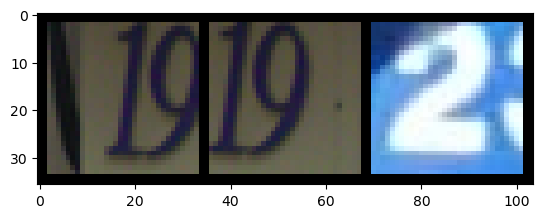

In [15]:
def matplotlib_imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(data_loader)
images, labels = next(dataiter)
images = images[:3]
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid)
print('The encoded labels of the images are {0}:'.format(labels[:3]))

In [16]:
del data_set
del data_loader
del output

In [17]:
transformer = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean_set, std=std_set)
    ])

train_data_set = SVHN(root='data/SVHN', split='train', transform=transformer)
test_data_set = SVHN(root='data/SVHN', split='test', transform=transformer)

#### Data Augmentation

In [18]:
transformer_augment = torchvision.transforms.Compose([
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean_set, std=std_set)
    ])

train_augment_data_set = SVHN(root='data/SVHN', split='train', transform=transformer_augment)
train_data_set = torch.utils.data.ConcatDataset([train_data_set, train_augment_data_set])
del(train_augment_data_set)

In [19]:
print('The size of the train dataset is; {0}'.format(len(train_data_set)))
print('The size of the test dataset is; {0}'.format(len(test_data_set)))

The size of the train dataset is; 146514
The size of the test dataset is; 26032


In [20]:
train_data_loader = torch.utils.data.DataLoader(train_data_set, batch_size=int(len(train_data_set)/32), shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_data_set, batch_size=int(len(test_data_set)/32), shuffle=True)

#### Model Building

In [21]:
labels = []

for _, label in train_data_set:
    labels.append(label)
labels = list(set(labels))
print("Output labels {0}".format(labels))

Output labels [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [22]:
multiclass_accuracy  = MulticlassAccuracy(num_classes=len(labels)).to(device=MPS)

In [23]:
class AlexNetSVHN(torch.nn.Module):
    
    def __init__(self, input_size):
        super(AlexNetSVHN,self).__init__()
    
        self.max_pool = torch.nn.MaxPool2d(kernel_size=2)
        
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11)
        conv1_size = self._get_conv_output_size(input_size, self.conv1.padding[0], self.conv1.stride[0], self.conv1.kernel_size[0])
        pool1_size = self._get_conv_output_size(conv1_size, self.max_pool.padding, self.max_pool.stride, self.max_pool.kernel_size)
        
        self.conv2 = torch.nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2)
        conv2_size = self._get_conv_output_size(pool1_size, self.conv2.padding[0], self.conv2.stride[0], self.conv2.kernel_size[0])
        pool2_size = self._get_conv_output_size(conv2_size, self.max_pool.padding, self.max_pool.stride, self.max_pool.kernel_size)
        
        self.conv3 = torch.nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1)
        conv3_size = self._get_conv_output_size(pool2_size, self.conv3.padding[0], self.conv3.stride[0], self.conv3.kernel_size[0])
        
        self.conv4 = torch.nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1)
        conv4_size = self._get_conv_output_size(conv3_size, self.conv4.padding[0], self.conv4.stride[0], self.conv4.kernel_size[0])
        
        self.conv5 = torch.nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1)
        conv5_size = self._get_conv_output_size(conv4_size, self.conv5.padding[0], self.conv5.stride[0], self.conv5.kernel_size[0])
        pool3_size = self._get_conv_output_size(conv5_size, self.max_pool.padding, self.max_pool.stride, self.max_pool.kernel_size)
        
        self.linear1 = torch.nn.Linear(in_features=self.conv5.out_channels*pool3_size*pool3_size, out_features=4096)
        self.linear2 = torch.nn.Linear(in_features=4096, out_features=4096)
        self.linear3 = torch.nn.Linear(in_features=4096, out_features=10)
        
        self.softmax = torch.nn.Softmax(dim=1)
        
    
    def _get_conv_output_size(self,input_size, padding, stride, kernel_size):
        return ((input_size+ (2* padding) - kernel_size)//stride)+1
        
    
    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.max_pool(x)
        
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = self.max_pool(x)
        
        x = self.conv3(x)
        x = torch.nn.functional.relu(x)
        
        x = self.conv4(x)
        x = torch.nn.functional.relu(x)
        
        x = self.conv5(x)
        x = torch.nn.functional.relu(x)
        x = self.max_pool(x)
        
        x = torch.flatten(x, start_dim=1)
        x = self.linear1(x)
        x = torch.nn.functional.relu(x)
        
        x = self.linear2(x)
        x = torch.nn.functional.relu(x)
        
        x = self.linear3(x)
        x = self.softmax(x)
        
        return x

In [24]:
torch.manual_seed(18)
svhn_alx_model =AlexNetSVHN(32).to(device=MPS)
svhn_alx_model

AlexNetSVHN(
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(1, 1))
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear1): Linear(in_features=1024, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=4096, bias=True)
  (linear3): Linear(in_features=4096, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [25]:
EPOCHS = 55
optimizer = torch.optim.Adam(svhn_alx_model.parameters(), lr=3e-4)

In [26]:
output_metrics = training_loop(svhn_alx_model,train_data_loader,test_data_loader,EPOCHS,loss_criteria,optimizer)

/Users/shri/Documents/ESDS/Semester_1/Intro_To_Machine_Learning/Assignment_2/env/lib/python3.8/site-packages/torchmetrics/functional/classification/stat_scores.py:416: UserWarning: MPS: no support for int64 reduction ops, casting it to int32 (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/ReduceOps.mm:144.)
  fp = confmat.sum(0) - tp


For Epoch 5 We Train Loss:1.9868299130237463, Test Loss:1.8558963537216187, Train Accuracy:0.357453010298989, Test Accuracy:0.4690393805503845
For Epoch 10 We Train Loss:1.7872379331877737, Test Loss:1.7424217462539673, Train Accuracy:0.5813301566875342, Test Accuracy:0.6235061883926392
For Epoch 15 We Train Loss:1.790898601214091, Test Loss:1.7205679416656494, Train Accuracy:0.5800779805038915, Test Accuracy:0.6283711791038513
For Epoch 20 We Train Loss:1.7333851185711948, Test Loss:1.7433792352676392, Train Accuracy:0.682148839488174, Test Accuracy:0.6695066690444946
For Epoch 25 We Train Loss:1.7660515669620398, Test Loss:1.6588523387908936, Train Accuracy:0.6604443589846293, Test Accuracy:0.7632443308830261
For Epoch 30 We Train Loss:1.6220758358637493, Test Loss:1.5804967880249023, Train Accuracy:0.8072480414852952, Test Accuracy:0.8349697589874268
For Epoch 35 We Train Loss:1.619980306336374, Test Loss:1.6216260194778442, Train Accuracy:0.804080838506872, Test Accuracy:0.81657576

In [33]:
print('The testing accuracy is: {0}'.format(output_metrics['testing_accuracy'][-1]*100))

The testing accuracy is: 91.4186954498291


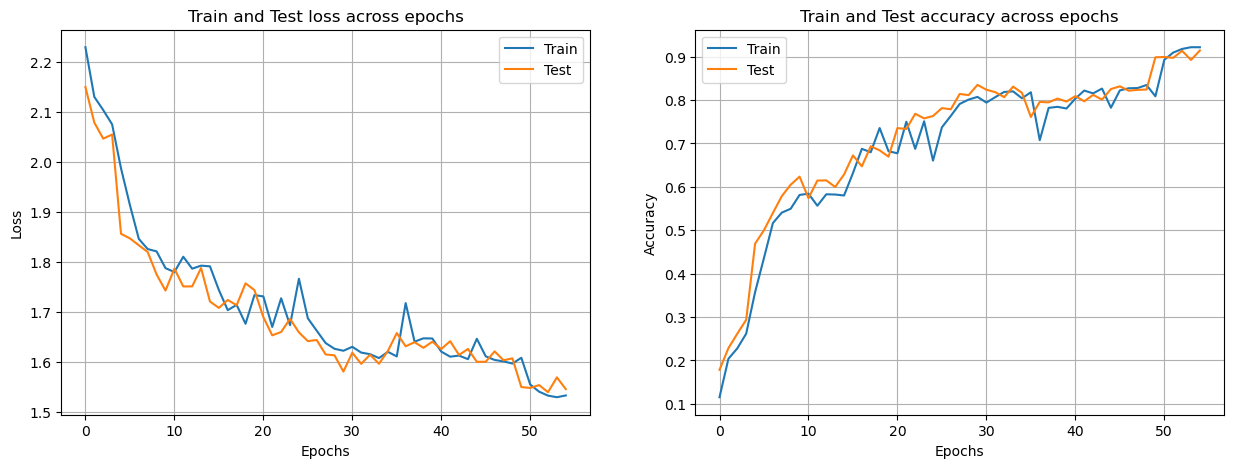

In [27]:
plot_metrics(EPOCHS, output_metrics)

In [28]:
del(AlexNetSVHN)

#### References:
* Numpy: https://numpy.org/doc/stable/
* Pandas: https://pandas.pydata.org/docs/reference/index.html
* Matplotlib: https://matplotlib.org/stable/api/index.html
* Seaborn: https://seaborn.pydata.org/api.html
* PyTorch: https://pytorch.org/docs/stable/index.html
* PyTorch Tutorials: https://youtube.com/playlist?list=PL_lsbAsL_o2CTlGHgMxNrKhzP97BaG9ZN
* TorchVision: https://pytorch.org/vision/stable/index.html
* TorchMetrics: https://torchmetrics.readthedocs.io/en/stable/
* AlexNet: https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf
* VGG-13: https://arxiv.org/pdf/1409.1556.pdf
* SVHN Dataset: http://ufldl.stanford.edu/housenumbers/
* Earlystopping: https://www.educative.io/answers/what-is-early-stopping
* Mixed Precision Training in Pytorch: https://pytorch.org/docs/stable/notes/amp_examples.html
